In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches

import os
os.chdir("/Users/deweywang/Desktop/GitHub/HEVisum/")


# Training data preparation 

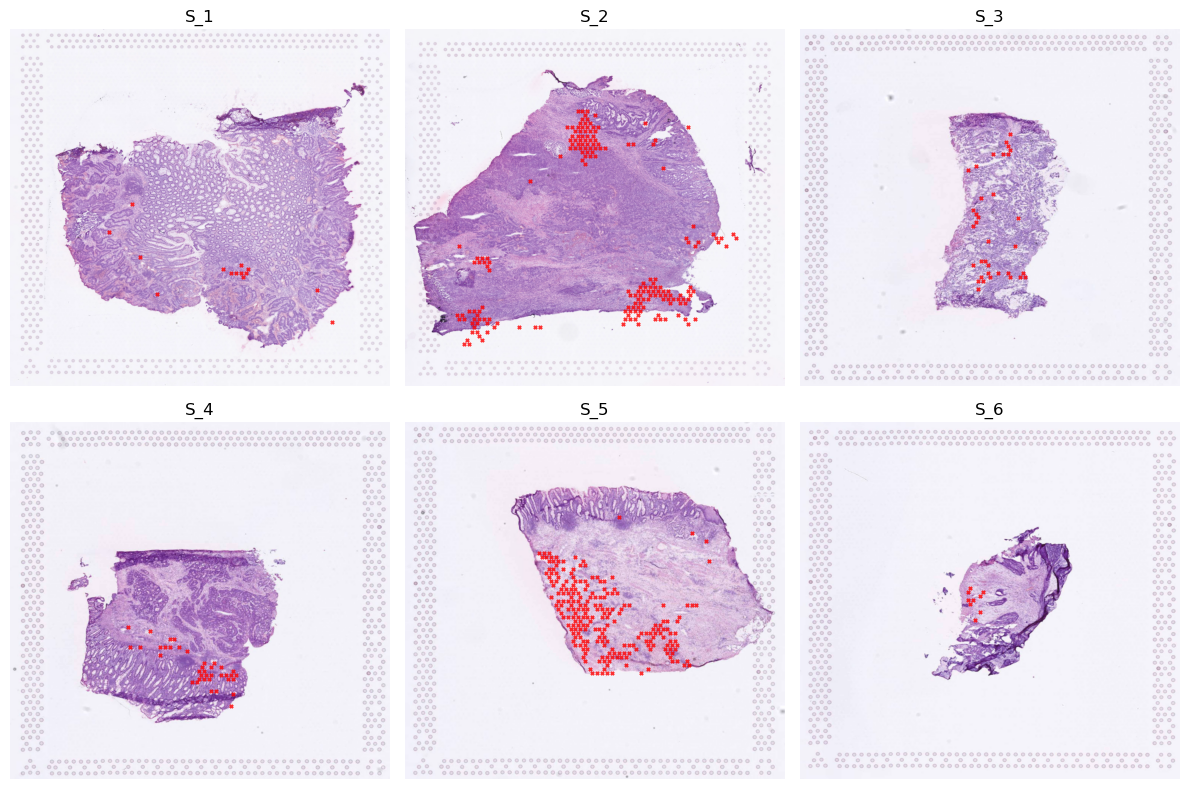

In [11]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Open the HDF5 file and load the Train images and spots datasets
with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Train"]
    train_spots = h5file["spots/Train"]

    # Get a list of all sample keys (slide identifiers)
    samples = list(train_images.keys())
    n_samples = len(samples)
    
    # Determine grid size (roughly square)
    cols = math.ceil(math.sqrt(n_samples))
    rows = math.ceil(n_samples / cols)
    
    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    # In case there's only one subplot, make it iterable
    axs = axs.flatten() if n_samples > 1 else [axs]
    
    # 在循环之前，先定义你的阈值
    THRESHOLD = 0.2  # 根据需要调整

    # … 省略前面打开 HDF5、grid 布局的部分 …

    for ax, sample in zip(axs, samples):
        image = np.array(train_images[sample])
        spots = np.array(train_spots[sample])
        x, y = spots["x"], spots["y"]

        # 先画所有点
        ax.imshow(image, aspect="auto")
        #ax.scatter(x, y, color="red", s=1, alpha=0.4)

        # --- 新增：标记那些所有 C1–C35 都 < THRESHOLD 的点 ---
        # 1) 找出字段名 C1–C35
        value_fields = [f"C{i}" for i in range(1, 36)]
        # 2) 取出一个 (n_spots,35) 的 array
        values = np.stack([spots[field] for field in value_fields], axis=1)
        # 3) 只要该行所有列都 < threshold，就标记
        mask = np.all(values < THRESHOLD, axis=1)
        # 4) 对应的 x,y
        x_bad = spots["x"][mask]
        y_bad = spots["y"][mask]
        # 5) 画出来
        ax.scatter(x_bad, y_bad, color="red", s=5, marker="x", alpha=0.8)

        ax.axis('off')
        ax.set_title(sample)
        
    # Hide any unused subplots (if the grid is larger than needed)
    for ax in axs[len(samples):]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [22]:
import os, h5py, cv2, math, numpy as np, pandas as pd

def image_quality_metrics(img):
    # img: H×W×3, uint8 或 uint16 或 float
    img_f = img.astype(np.float32)
    if img_f.max() > 1.5:              # → 0-255 or 0-65535
        img_f /= img_f.max()           # 轉 0-1
    mean  = img_f.mean(axis=(0,1))
    std   = img_f.std (axis=(0,1))

    under = (img_f < 10/255).mean()
    over  = (img_f > 245/255).mean()

    # --- 清晰度 ---
    gray  = cv2.cvtColor((img_f*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    sharp = cv2.Laplacian(gray, cv2.CV_32F).var()

    # --- 雜訊 proxy ---
    blur  = cv2.GaussianBlur(gray, (5,5), 0)
    noise = np.abs(gray.astype(np.float32) - blur).mean()
    return mean, std, under, over, sharp, noise



file_path = "./dataset/realign/original_data.h5"      # << 改成你的實際路徑

results = []
with h5py.File(file_path, "r") as h5:
    imgs = h5["images/Train"]
    for slide_id in imgs.keys():
        img = np.array(imgs[slide_id])                # H×W×3, uint8
        m, s, u, o, sh, nz = image_quality_metrics(img)
        results.append({
            "slide": slide_id,
            "mean_R": m[0], "mean_G": m[1], "mean_B": m[2],
            "std_R":  s[0], "std_G":  s[1], "std_B":  s[2],
            "pct_underexp": u,
            "pct_overexp":  o,
            "sharpness":    sh,
            "noise_metric": nz
        })

df = pd.DataFrame(results).round(4)
print(df)


  slide  mean_R  mean_G  mean_B   std_R   std_G   std_B  pct_underexp  \
0   S_1  0.8886  0.8342  0.9155  0.1175  0.1811  0.0976           0.0   
1   S_2  0.8720  0.8001  0.9005  0.1318  0.2118  0.1099           0.0   
2   S_3  0.9401  0.9188  0.9611  0.0865  0.1177  0.0718           0.0   
3   S_4  0.9130  0.8720  0.9378  0.1179  0.1822  0.0990           0.0   
4   S_5  0.9282  0.8895  0.9408  0.0827  0.1300  0.0790           0.0   
5   S_6  0.9503  0.9346  0.9689  0.0925  0.1276  0.0787           0.0   

   pct_overexp   sharpness  noise_metric  
0       0.3134  244.065094        2.5912  
1       0.3048  275.321594        2.6855  
2       0.2775   33.366199        0.9161  
3       0.2549   34.137901        1.0257  
4       0.2462   27.802700        0.9644  
5       0.3030   23.618401        0.6703  


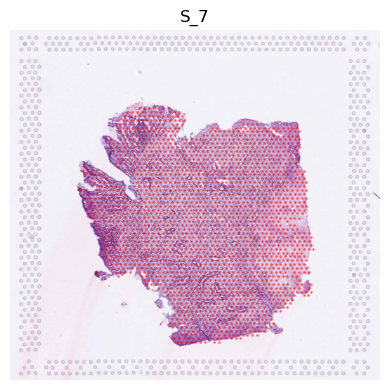

In [14]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

# Open the HDF5 file and load the Train images and spots datasets
with h5py.File("dataset/elucidata_ai_challenge_data.h5", "r") as h5file:
    train_images = h5file["images/Test"]
    train_spots = h5file["spots/Test"]

    # Get a list of all sample keys (slide identifiers)
    samples = list(train_images.keys())
    n_samples = len(samples)
    
    # Determine grid size (roughly square)
    cols = math.ceil(math.sqrt(n_samples))
    rows = math.ceil(n_samples / cols)
    
    # Create a figure with a grid of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    # In case there's only one subplot, make it iterable
    axs = axs.flatten() if n_samples > 1 else [axs]
    
    # Loop through each sample and plot the corresponding data
    for ax, sample in zip(axs, samples):
        image = np.array(train_images[sample])
        spots = np.array(train_spots[sample])
        x, y = spots["x"], spots["y"]

        ax.imshow(image, aspect="auto")
        ax.scatter(x, y, color="red", s=1, alpha=0.4)
        ax.axis('off')
        ax.set_title(sample)
        
    # Hide any unused subplots (if the grid is larger than needed)
    for ax in axs[len(samples):]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()


In [23]:
file_path = "dataset/elucidata_ai_challenge_data.h5"      # << 改成你的實際路徑

results = []
with h5py.File(file_path, "r") as h5:
    imgs = h5["images/Test"]
    for slide_id in imgs.keys():
        img = np.array(imgs[slide_id])                # H×W×3, uint8
        m, s, u, o, sh, nz = image_quality_metrics(img)
        results.append({
            "slide": slide_id,
            "mean_R": m[0], "mean_G": m[1], "mean_B": m[2],
            "std_R":  s[0], "std_G":  s[1], "std_B":  s[2],
            "pct_underexp": u,
            "pct_overexp":  o,
            "sharpness":    sh,
            "noise_metric": nz
        })

df = pd.DataFrame(results).round(4)
print(df)

  slide  mean_R  mean_G  mean_B   std_R  std_G   std_B  pct_underexp  \
0   S_7  0.8923    0.85  0.9222  0.1227  0.168  0.1035           0.0   

   pct_overexp  sharpness  noise_metric  
0       0.2134  88.388298        1.8637  


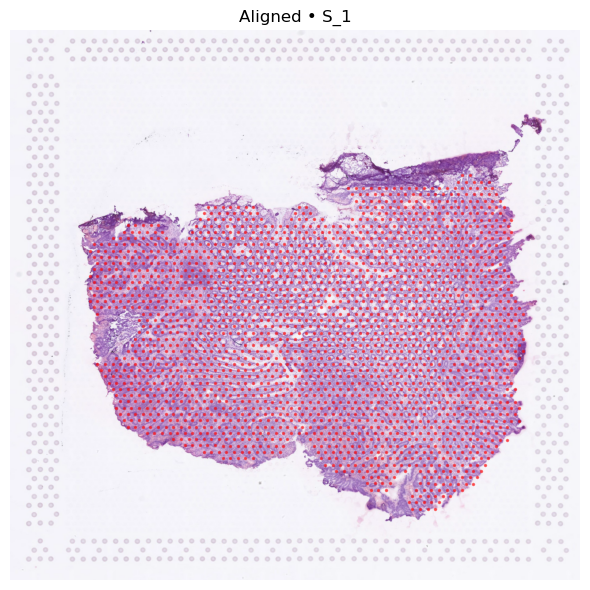

In [17]:
# ------------------------------------------------------------
# 完整、一次可跑的 JupyterLab Cell
# ------------------------------------------------------------
from __future__ import annotations
import sys
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import h5py
from typing import NamedTuple



# ---------- 資料結構 ---------- #
class SpotArray(NamedTuple):
    x: np.ndarray
    y: np.ndarray

    def shifted(self, dx: float, dy: float) -> "SpotArray":
        """回傳平移後的新座標（不改變原物件）。"""
        return SpotArray(self.x + dx, self.y + dy)

# ---------- 工具函式 ---------- #
def diameter_px_to_s(diameter_px: float, ax: plt.Axes) -> float:
    """
    把「像素直徑」轉成 plt.scatter 的 s 面積值 (pt²)。
    """
    if diameter_px <= 0:
        raise ValueError("diameter_px 必須為正")
    dpi = ax.figure.dpi
    diameter_pt = diameter_px * 72.0 / dpi   # px -> pt
    return diameter_pt ** 2                  # 面積 (pt²)

def align_and_plot(
    image: np.ndarray,
    spots: SpotArray,
    dx: float,
    dy: float,
    spot_diameter_px: float = 26.0,
    title: str | None = None,
    cmap: str = "gray"
) -> SpotArray:
    """
    手動平移 spots 並繪圖。
    回傳平移後的 SpotArray 供後續寫回或分析。
    """
    aligned = spots.shifted(dx, dy)

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap=cmap, aspect="auto")
    s_val = diameter_px_to_s(spot_diameter_px, ax)
    ax.scatter(aligned.x, aligned.y, s=s_val, c="red", alpha=0.5)

    ax.set_axis_off()
    if title:
        ax.set_title(title)
    plt.tight_layout()
    plt.show()

    return aligned


# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_1"          # 要顯示的切片
dx, dy            = -55, -60           # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)

# `aligned_spots` 變數現在就握有校正後的座標，可再寫回 HDF5 或做後續分析


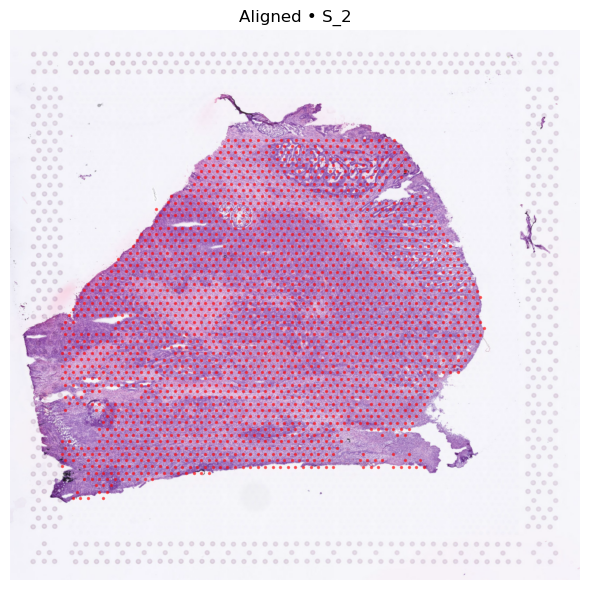

In [9]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_2"          # 要顯示的切片
dx, dy            = -90, -60          # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


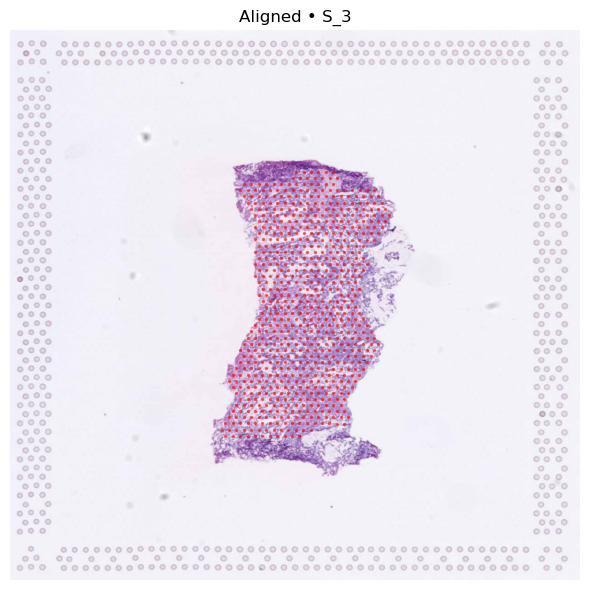

In [33]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_3"          # 要顯示的切片
dx, dy            = -25, -25          # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


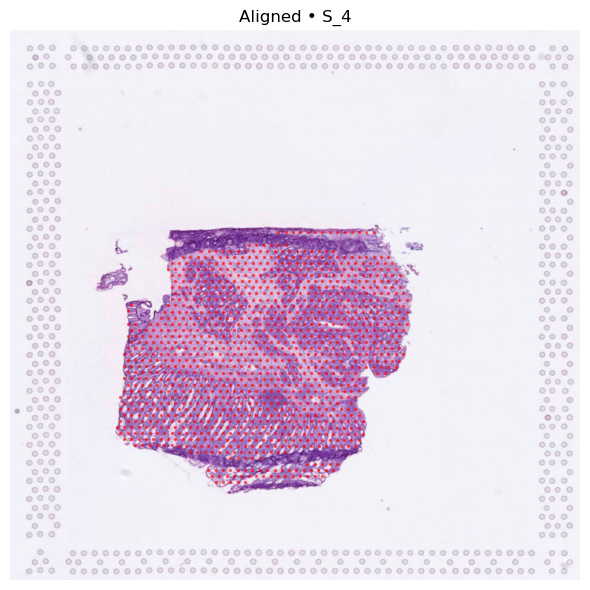

In [41]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_4"          # 要顯示的切片
dx, dy            = -15, -15         # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


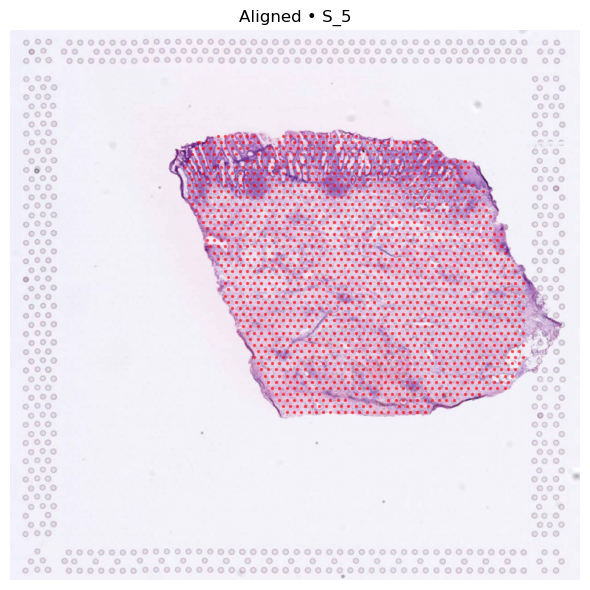

In [42]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_5"          # 要顯示的切片
dx, dy            = -15, -15         # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


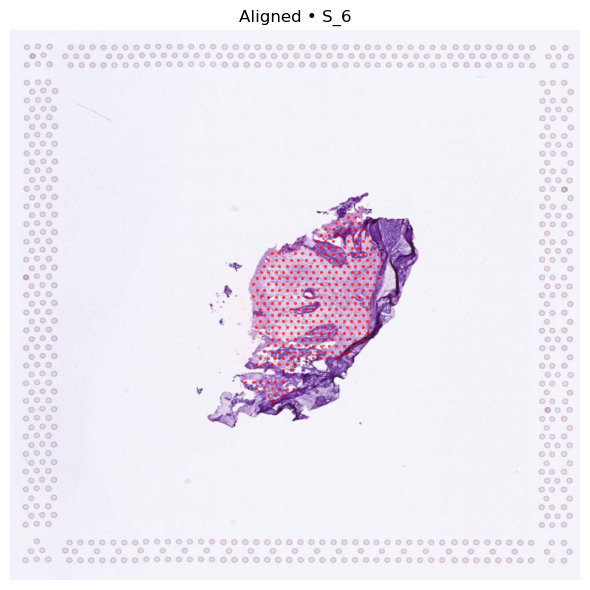

In [37]:
# ---------- 使用者設定 ---------- #
h5_path           = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
slide_id          = "S_6"          # 要顯示的切片
dx, dy            = -30, -30          # <-- 這裡輸入平移量
spot_diameter_px  = 2                 # spot 直徑 (px)，保持 26 即可

# ---------- 讀取 HDF5 & 執行 ---------- #
if not h5_path.exists():
    raise FileNotFoundError(h5_path)

with h5py.File(h5_path, "r") as h5:
    img  = np.array(h5["images/Train"][slide_id])
    rec  = np.array(h5["spots/Train"][slide_id])
    raw_spots = SpotArray(x=rec["x"], y=rec["y"])

aligned_spots = align_and_plot(
    image=img,
    spots=raw_spots,
    dx=dx, dy=dy,
    spot_diameter_px=spot_diameter_px,
    title=f"Aligned • {slide_id}"
)


In [ ]:
# ------------------------------------------------------------
# 複製全部切片，僅對指定 slide 平移 spots
# ------------------------------------------------------------
from __future__ import annotations
import numpy as np
import h5py
import pathlib

# ---------- 路徑設定 ---------- #
src_h5 = pathlib.Path("./dataset/elucidata_ai_challenge_data.h5")
dst_h5 = pathlib.Path("./dataset/realign/only_1_v2/original_data.h5")
dst_h5.parent.mkdir(parents=True, exist_ok=True)  # 確保資料夾存在

# ---------- 各 slide 的平移量 ---------- #
slide_offsets: dict[str, tuple[float, float]] = {
    "S_1": (-55, -60),
    "S_2": (-90, -60),
    "S_3": (-25, -25),
    "S_4": (-15, -15),
    "S_5": (-15, -15),
    "S_6": (-30, -30),
}
slide_offsets: dict[str, tuple[float, float]] = {
    "S_1": (-55, -60),
    "S_2": (-90, -60),
}
# ---------- 讀來源、寫目的 ---------- #
with h5py.File(src_h5, "r") as src, h5py.File(dst_h5, "w") as dst:
    img_src  = src["images/Train"]
    spot_src = src["spots/Train"]
    img_dst  = dst.create_group("images/Train")
    spot_dst = dst.create_group("spots/Train")

    # ---- 複製所有影像 ---- #
    for slide in img_src.keys():
        img_dst.create_dataset(
            slide,
            data=np.array(img_src[slide]),
            compression="gzip"
        )

    # ---- 處理 / 複製所有 spots ---- #
    for slide in spot_src.keys():
        rec = np.array(spot_src[slide])           # compound dtype
        if slide in slide_offsets:
            dx, dy = slide_offsets[slide]
            rec = rec.copy()                      # 不影響來源 buffer
            rec["x"] = rec["x"] + dx
            rec["y"] = rec["y"] + dy
        spot_dst.create_dataset(
            slide,
            data=rec,
            dtype=rec.dtype,
            compression="gzip"
        )

print(
    "✅ 完成！已將全部影像與 spots 寫入\n"
    f"   {dst_h5}\n"
    "   （已平移下列 slide 的座標："
    + ", ".join(slide_offsets.keys()) + "）"
)


✅ 完成！已將全部影像與 spots 寫入
   dataset/realign/only_1-2_v3/original_data.h5
   （已平移下列 slide 的座標：S_1, S_2）
